#### INF2604 – Computational Geometry
### Assignment II - Polygon triangulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
_EPS = 1**-9
INF = 2048

class point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.mag = self.magnitude()
        
    def dist(self, p):
        return np.sqrt(np.power((p.x - self.x), 2) + np.power((p.y - self.y), 2))
    
    def is_in(self, circle):
        d = self.dist(circle.c)

        if d <= circle.r: # considering p inside circle when p is on circle
            return True
        else:
            return False

    def collinear(self, pi, pj):
        m = np.array([
                        [1, self.x, self.y],
                        [1, pi.x, pi.y],
                        [1, pj.x, pj.y]
                     ])
        m_det = np.linalg.det(m)
        return np.fabs(m_det) <= _EPS
    
    def minus(self, p):
        return point(self.x - p.x, self.y - p.y)
    
    def plus(self, p):
        return point(self.x + p.x, self.y + p.y)
    
    def scalar_mult(self, alpha):
        return point(self.x * alpha, self.y * alpha)
    
    def magnitude(self):
        return np.sqrt(self.x * self.x + self.y * self.y)
    
    def normalization(self):
        m = self.magnitude()
        return point(self.x / m, self.y / m)
    
    def equal(self, p):
        return self.x == p.x and self.y == p.y

In [3]:
points = list()

filename = 'polygon1.txt'

with open(filename, 'r') as f:
    for line in f:
        line = line.split()
        points.append(point(float(line[0]), float(line[1])))

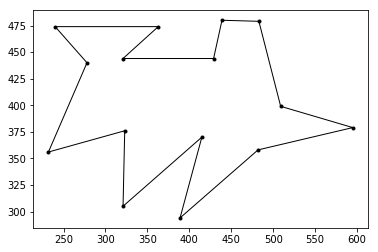

In [4]:
fig, ax = plt.subplots()
ax.scatter([p.x for p in points], [p.y for p in points], marker='.', color='black')
polygon = plt.Polygon(np.array([[p.x, p.y] for p in points]), edgecolor='black', facecolor='none')

ax.add_artist(polygon)

plt.show()

### Auxiliary functions

In [5]:
def get_diagonals(points):
    diagonals = list()
    for i in range(len(points)):
        for j in range(len(points)):
            if i != j:
                diagonals.append((points[i], points[j]))

    return diagonals

In [6]:
def get_edges(points):
    edges = list()
    n = len(points)

    for i in range(n - 1):
        edges.append((points[i], points[i+1]))
    
    edges.append((points[n-1], points[0]))
    
    return edges

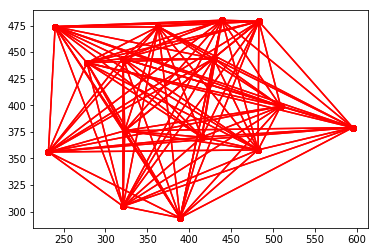

In [7]:
diagonals = get_diagonals(points)

for d in diagonals:
    plt.plot([d[0].x, d[1].x], [d[0].y, d[1].y], 'ro-')

plt.show()

In [8]:
def intersection(a, b, c, d):
    m_abc = np.array([
                [1, a.x, a.y],
                [1, b.x, b.y],
                [1, c.x, c.y]
             ])
    
    m_abd = np.array([
                [1, a.x, a.y],
                [1, b.x, b.y],
                [1, d.x, d.y]
             ])
    
    m_cda = np.array([
                [1, c.x, c.y],
                [1, d.x, d.y],
                [1, a.x, a.y]
             ])
    
    m_cdb = np.array([
                [1, c.x, c.y],
                [1, d.x, d.y],
                [1, b.x, b.y]
             ])
    
    m_abc_det = np.linalg.det(m_abc)
    m_abd_det = np.linalg.det(m_abd)
    m_cda_det = np.linalg.det(m_cda)
    m_cdb_det = np.linalg.det(m_cdb)
    
    if ((m_abc_det < 0 and m_abd_det > 0) or (m_abc_det > 0 and m_abd_det < 0)) and ((m_cda_det < 0 and m_cdb_det > 0) or (m_cda_det > 0 and m_cdb_det < 0)):
        return True
    else:
        return False

In [9]:
def is_in_polygon(p, polygon_edges):
    n = 0
    r = point(INF, p.y)
    for e in polygon_edges:
        if intersection(p, r, e[0], e[1]):
            n += 1
    
    if n % 2 == 0:
        return False
    else:
        return True

In [10]:
def is_a_boundary(diagonal, polygon_edges):
    for e in polygon_edges:
        if (diagonal[0].equal(e[0]) and diagonal[1].equal(e[1])) or (diagonal[0].equal(e[1]) and diagonal[1].equal(e[0])):
            return True
    return False

In [11]:
def have_a_intersection(diagonal, polygon_edges):
    for e in polygon_edges:
        if (intersection(diagonal[0], diagonal[1], e[0], e[1])):
            return True
    return False

In [12]:
def split_polygon(seg_line, polygon_edges):
    left = list()
    right = list()
    
    ext_1 = seg_line[0]
    ext_2 = seg_line[1]
    
    i = 0
    
    while (not ext_1.equal(polygon_edges[i][0])):
        i += 1
    
    new_list = polygon_edges[i:] + polygon_edges[:i]
    
    for j in range(len(new_list)):
        if ext_2.equal(new_list[j][1]):
            left.append(new_list[j])
            break
        else:
            left.append(new_list[j])
            
    for k in range(j + 1, len(new_list)):
        right.append(new_list[k])
            
    return left, right

In [13]:
def extract_vertexes(polygon_edges):
    n = len(polygon_edges)
    vertexes = list()
    
    if n % 2 == 0:
        for e in polygon_edges[::2]:
            vertexes.append(e[0])
            vertexes.append(e[1])
        
        vertexes.append(polygon_edges[n-1][1])
    
    else:
        for e in polygon_edges[::2]:
            vertexes.append(e[0])
            vertexes.append(e[1])
        
    return vertexes

### Algorithm diagonals insertion

In [14]:
def triangulation(points, solution, plot=False):
    
    if len(points) == 3:
        return solution
    
    diagonals = get_diagonals(points)
    polygon_edges = get_edges(points)
    
    for d in diagonals:
        if not is_a_boundary(d, polygon_edges) and not have_a_intersection(d, polygon_edges):
        
            mp = point((d[0].x + d[1].x) / 2.0, (d[0].y + d[1].y) / 2.0)
            if is_in_polygon(mp, polygon_edges):
                left, right = split_polygon(d, polygon_edges)
                p_left = extract_vertexes(left)
                p_right = extract_vertexes(right)
                
                if plot:
                    for p in left:
                        plt.plot([p[0].x, p[1].x], [p[0].y, p[1].y], 'bo-')
                    for p in right:
                        plt.plot([p[0].x, p[1].x], [p[0].y, p[1].y], 'ro-')

                    plt.plot([d[0].x, d[1].x], [d[0].y, d[1].y], 'go-')
                    plt.show()
                    
                solution.add(d)
                p1 = triangulation(p_left, solution, plot)
                p2 = triangulation(p_right, solution, plot)
    
                return p1.union(p2)
    
    return solution

In [15]:
# set plot=True to see step by step
solution = triangulation(points, set(), plot=False)

fig, ax = plt.subplots()
ax.scatter([p.x for p in points], [p.y for p in points], marker='.', color='black')
polygon = plt.Polygon(np.array([[p.x, p.y] for p in points]), edgecolor='black', facecolor='none')

ax.add_artist(polygon)

for d in solution:
    plt.plot([d[0].x, d[1].x], [d[0].y, d[1].y], 'r.-')
plt.show()

### Write outputfile

In [16]:
def export_solution(solution, filename):
    with open(filename, 'w') as f:
        for d in solution:
            vi, vj = points.index(d[0]), points.index(d[1])
            f.write('{}\t{}\n'.format(vi, vj))

In [17]:
export_solution(solution, 'diagonals.txt')